This script analyze the output of O<sub>3</sub> box model with source apportionment technique. The goal of this script is to find the O<sub>3</sub> contribution from different source of VOCs from the box model for Redlands, CA

In [3]:
import os, importlib, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import join, isfile
sys.path.append('../../code/src')
#importlib.reload(sys.modules['box_model_source_apportionment'])
from box_model_source_apportionment import treat_box_model_output

In [4]:
df_all = pd.DataFrame(columns=['Date','Time','O3','O3_X1','O3_X2','O3_X3',
                                 'O3_X4','O3_X5','O3_X6',
                                 'O3_X7','O3_X8','O3_X9'])
folderpath = '../../data/intermediate/box_model_output_bgX/'
filelist = [f for f in listdir(folderpath) if 
            isfile(join(folderpath, f))]
filelist = [s for s in filelist if 'results' in s ]

for file in filelist:
    filepath = folderpath + file
    df = treat_box_model_output(filepath)
    df_all = pd.concat([df_all, df], ignore_index=True)
#df_all.to_csv('../../data/final/box_model_source_O3_time.csv')

# Precentage of PMF-input VOCs formed O<sub>3</sub> to total O<sub>3</sub> formation 

In [5]:
df_O3_source_avg = pd.DataFrame(df_all[df_all['Time']==180].iloc[:,2:].mean(axis=0))
df_O3_source_avg.columns = ['Value']

# Subtract the initial O3 from final O3_vanilla
O3_init_avg = df_all[df_all['Time']==0].iloc[:,2:].mean(axis=0)[0]
df_O3_source_avg.iloc[0,0] = df_O3_source_avg.iloc[0,0] - O3_init_avg

# calculate the percentage to sum
df_O3_source_avg['Percentage'] = df_O3_source_avg['Value']/df_O3_source_avg['Value'].sum()*100

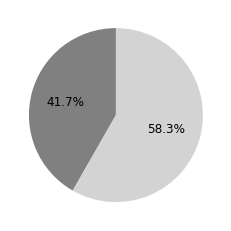

In [6]:
O3_not_in_PMF = df_O3_source_avg.loc['O3','Percentage']
O3_in_PMF = 100 - O3_not_in_PMF
pie = [O3_not_in_PMF, O3_in_PMF]

fig, ax = plt.subplots(1, figsize=(4,4))
ax.pie(pie, autopct='%1.1f%%',
        shadow=False, startangle=90, colors = ['grey','lightgrey'], 
        textprops={'fontsize': 12})
fig.set_facecolor('white')
fig.savefig('../../result/pie_model_PMFinput_vs_notinPMF.png', dpi=1200, bbox_inches='tight')

# O<sub>3</sub> source apportionment of PMF-solved factors

C:\Users\Shenglun\AppData\Local\Temp/ipykernel_10116/1922002067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_O3_source_novanilla['Precentage'] = \


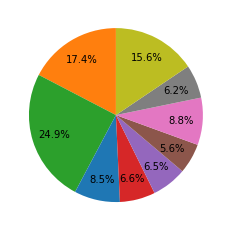

In [7]:
# calculate precentage without vanilla O3
df_O3_source_novanilla = df_O3_source_avg.iloc[1:,:]
df_O3_source_novanilla['Precentage'] = \
    df_O3_source_novanilla['Value']/df_O3_source_novanilla['Value'].sum()

# reorder source of O3 to match the order in OFP analysis
idx = ['O3_X1','O3_X3','O3_X5','O3_X4','O3_X9','O3_X8','O3_X6','O3_X7','O3_X2']
df_O3_source_novanilla = df_O3_source_novanilla.loc[idx,:]

# make pie chart (no vanilla)
fig, ax=plt.subplots(1)
factor_name = ['Plant decomposition', 'Biogenic', 'Summer blend gasoline',
               'Winter blend gasoline', 'institutional refrigerator, air conditioning, cooking', 'Education institution', 'Commercial and industrial solvents', 
               'VCP(siloxane)', 'VCP(EtOH)']
color = ['#ff7f0e','#2ca02c','#1f77b4', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

ax.pie(df_O3_source_novanilla['Percentage'],labels=None,colors=color, 
       autopct='%.1f%%',pctdistance=0.75,shadow=False,startangle=90,
       textprops={'fontsize': 10})
fig.set_facecolor('white')
fig.savefig('../../result/pie_model_O3_source.png', dpi=1200, bbox_inches='tight')

## source O3 as a function of O3

In [8]:
# O3 data (MDA8 O3)
df_O3_MDA8 = pd.read_csv('../../data/final/MDA8_O3_redlands.csv')
df_O3_MDA8['Date'] = pd.to_datetime(df_O3_MDA8['Date'])

# O3 data (chamber O3)
df_O3_chamber = pd.read_csv('../../data/final/O3_sensitivity_redlands.csv')
df_O3_chamber['Date'] = pd.to_datetime(df_O3_chamber['Date'])

In [9]:
# change name of column to use factor name
df_all = df_all[['Date','Time','O3','O3_X1','O3_X3','O3_X5','O3_X4',
        'O3_X9','O3_X8','O3_X6','O3_X7','O3_X2']]
df_all.iloc[:,2:] = df_all.iloc[:,2:]*1e3
column_name = ['Date','Time','Vanilla','Plant decomposition', 'Biogenic', 
               'Summer blend gasoline', 'Winter blend gasoline', 
               'institutional refrigerator, air conditioning, cooking',
               'Education institution', 'Commercial and industrial solvents',
               'VCP(siloxane)', 'VCP(EtOH)']
df_all.columns = column_name

#### Source O3 vs. MDA8 O3

Text(0, 0.5, '$O_3$ from each source (ppbv)')

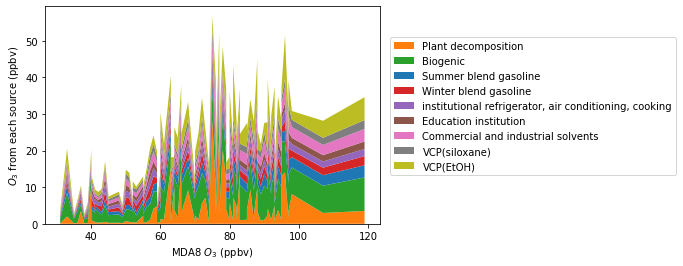

In [10]:
df_plot = df_all.loc[df_all['Time']==180, :].reset_index(drop=True)
df_plot['Vanilla'] = df_plot['Vanilla'] - df_all[df_all['Time']==0].reset_index()['Vanilla']
df_plot = df_plot.merge(df_O3_MDA8[['Date','MDA8']], on='Date', how='left')
df_plot = df_plot.merge(df_O3_chamber[['Date','bag2_3hr','b1_b2_3hr']], on='Date', how='left')

df_plot = df_plot.sort_values(by='MDA8').reset_index(drop=True)
plt.stackplot(df_plot['MDA8'], df_plot.iloc[:,3], 
              df_plot.iloc[:,4],
              df_plot.iloc[:,5],df_plot.iloc[:,6],df_plot.iloc[:,7],df_plot.iloc[:,8],
              df_plot.iloc[:,9], df_plot.iloc[:,10],df_plot.iloc[:,11], 
              labels=df_plot.columns[3:], colors=color)
plt.legend(bbox_to_anchor=(1.9, 0.88))
plt.xlabel('MDA8 $O_3$ (ppbv)')
plt.ylabel('$O_3$ from each source (ppbv)')

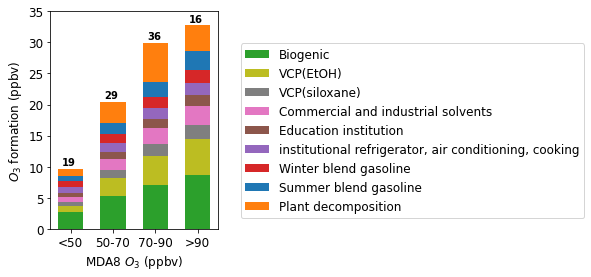

In [11]:
# bin by MDA8 O3 50,70,90
df_plot['MDA8_bin'] = pd.cut(df_plot['MDA8'], bins=[0,50,70,90,120], 
                             labels=['<50','50-70','70-90','>90'])
df_plot_bin = df_plot.groupby('MDA8_bin').mean()
df_plot_bin = df_plot_bin[['Vanilla','Biogenic','VCP(EtOH)','VCP(siloxane)','Commercial and industrial solvents','Education institution','institutional refrigerator, air conditioning, cooking','Winter blend gasoline','Summer blend gasoline','Plant decomposition']]
color_new = ['#2ca02c','#bcbd22','#7f7f7f','#e377c2','#8c564b','#9467bd','#d62728','#1f77b4','#ff7f0e']

# set text size
plt.rcParams.update({'font.size': 12})

fig, ax=plt.subplots(1, figsize=(3, 4))

x = df_plot_bin.index
bottom = np.zeros(len(x))

for i in np.arange(1,10,1):
    ax.bar(x, df_plot_bin.iloc[:,i], width=0.6,
           bottom=bottom, label=df_plot_bin.columns[i], color=color_new[i-1])
    bottom = bottom + df_plot_bin.iloc[:,i]

sample_size = df_plot.groupby('MDA8_bin').count().iloc[:,0]
for j in range(4):
    ax.text(j-0.2, bottom[j]+0.5, str(sample_size[j]), fontsize=10, fontweight='bold')

ax.set_ylim(0,35)
ax.legend(bbox_to_anchor=(1.1, 0.88))
ax.set_xlabel('MDA8 $O_3$ (ppbv)')
ax.set_ylabel('$O_3$ formation (ppbv)')
fig.savefig('../../result/bar_O3_source_vs_MDA8O3.png', dpi=1200, bbox_inches='tight',facecolor='white')

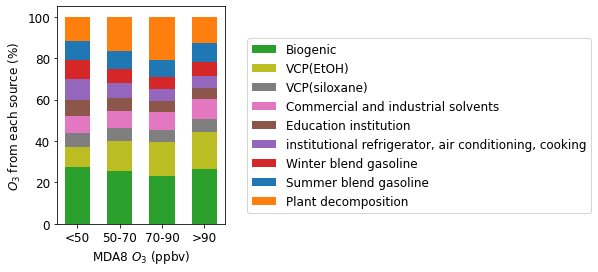

In [13]:
# calculate percentage
df_plot_bin['O3_tot'] = df_plot_bin.iloc[:,1:10].sum(axis=1)
for i in np.arange(1,10,1):
    df_plot_bin.iloc[:,i] = df_plot_bin.iloc[:,i]/df_plot_bin['O3_tot']*100

# plot
fig, ax=plt.subplots(1, figsize=(3, 4))
x = df_plot_bin.index
bottom = np.zeros(len(x))

for i in np.arange(1,10,1):
    ax.bar(x, df_plot_bin.iloc[:,i], width=0.6,
           bottom=bottom, label=df_plot_bin.columns[i], color=color_new[i-1])
    bottom = bottom + df_plot_bin.iloc[:,i]
ax.legend(bbox_to_anchor=(1.1, 0.88))
ax.set_xlabel('MDA8 $O_3$ (ppbv)')
ax.set_ylabel('$O_3$ from each source (%)')
fig.savefig('../../result/bar_O3_source_vs_MDA8O3_precentage.png', dpi=1200, bbox_inches='tight',facecolor='white')

#### source O3 vs. $\Delta O_3^{+NO_x}$

Text(0, 0.5, 'O3 from each source (ppbv)')

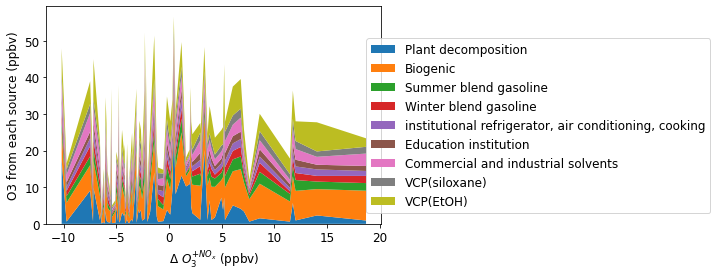

In [15]:
df_plot = df_all.loc[df_all['Time']==180, :].reset_index(drop=True)
df_plot['Vanilla'] = df_plot['Vanilla'] - df_all[df_all['Time']==0].reset_index()['Vanilla']
df_plot = df_plot.merge(df_O3_MDA8[['Date','MDA8']], on='Date', how='left')
df_plot = df_plot.merge(df_O3_chamber[['Date','bag2_3hr','b1_b2_3hr']], on='Date', how='left')

df_plot.sort_values(by='b1_b2_3hr', inplace=True)
plt.stackplot(df_plot.loc[:,'b1_b2_3hr'], df_plot.iloc[:,3], 
              df_plot.iloc[:,4],
              df_plot.iloc[:,5],df_plot.iloc[:,6],df_plot.iloc[:,7],df_plot.iloc[:,8],
              df_plot.iloc[:,9], df_plot.iloc[:,10],df_plot.iloc[:,11], 
              labels=df_plot.columns[3:])
plt.legend(bbox_to_anchor=(2, 0.88))
plt.xlabel('$\Delta\ O_3^{+NO_x}$ (ppbv)')
plt.ylabel('O3 from each source (ppbv)')

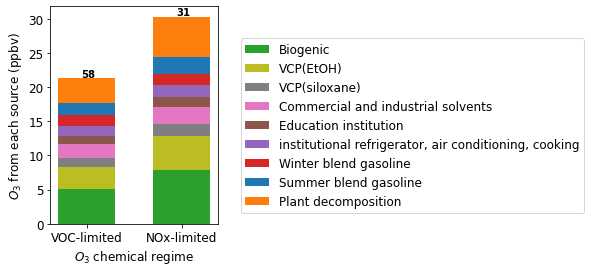

In [16]:
# bin by O3 sensitivity
df_plot = df_plot[(df_plot['b1_b2_3hr'].notna())]
df_plot['O3_sensitivity_bin'] = pd.cut(df_plot['b1_b2_3hr'], bins=[-20,0,20], 
                             labels=['VOC-limited','NOx-limited'])
df_plot_bin = df_plot.groupby('O3_sensitivity_bin').mean()
df_plot_bin = df_plot_bin[['Vanilla','Biogenic','VCP(EtOH)','VCP(siloxane)','Commercial and industrial solvents','Education institution','institutional refrigerator, air conditioning, cooking','Winter blend gasoline','Summer blend gasoline','Plant decomposition']]

fig, ax=plt.subplots(1, figsize=(3, 4))

x = df_plot_bin.index
bottom = np.zeros(len(x))

for i in np.arange(1,10,1):
    ax.bar(x, df_plot_bin.iloc[:,i], width=0.6,
           bottom=bottom, label=df_plot_bin.columns[i], color=color_new[i-1])
    bottom = bottom + df_plot_bin.iloc[:,i]

sample_size = df_plot.groupby('O3_sensitivity_bin').count().iloc[:,0]
for j in range(2):
    ax.text(j-0.06, bottom[j]+0.2, str(sample_size[j]), fontsize=10, fontweight='bold')

ax.legend(bbox_to_anchor=(1.1, 0.88))
ax.set_xlabel('$O_3$ chemical regime')
ax.set_ylabel('$O_3$ from each source (ppbv)')
fig.savefig('../../result/bar_O3_source_vs_O3_sensitivity.png', dpi=1200, bbox_inches='tight',facecolor='white')

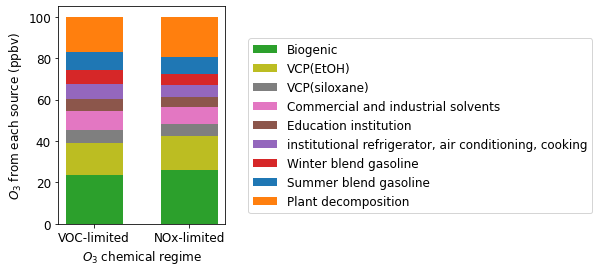

In [18]:
# calculate percentage
df_plot_bin['O3_tot'] = df_plot_bin.iloc[:,1:10].sum(axis=1)
for i in np.arange(1,10,1):
    df_plot_bin.iloc[:,i] = df_plot_bin.iloc[:,i]/df_plot_bin['O3_tot']*100

# plot
fig, ax=plt.subplots(1, figsize=(3, 4))
x = df_plot_bin.index
bottom = np.zeros(len(x))

for i in np.arange(1,10,1):
    ax.bar(x, df_plot_bin.iloc[:,i], width=0.6,
           bottom=bottom, label=df_plot_bin.columns[i], color=color_new[i-1])
    bottom = bottom + df_plot_bin.iloc[:,i]
ax.legend(bbox_to_anchor=(1.1, 0.88))
ax.set_xlabel('$O_3$ chemical regime')
ax.set_ylabel('$O_3$ from each source (ppbv)')
fig.savefig('../../result/bar_O3_source_vs_O3_sensitivity_precentage.png', dpi=1200, bbox_inches='tight',facecolor='white')

In [20]:
df_NOx = pd.read_csv('../../data/final/daily_avg_initial_NOx_conc_redlands.csv')
df_NOx['Date'] = pd.to_datetime(df_NOx['Date'])

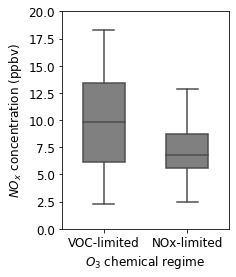

In [39]:
import seaborn as sns

df_plot_NOx = df_plot.merge(df_NOx, on='Date', how='left')
df_plot_NOx = df_plot_NOx[(df_plot_NOx['b1_b2_3hr'].notna())&(df_plot_NOx['NOx']>2)]
df_plot_NOx.loc[df_plot_NOx['b1_b2_3hr']<0,'O3_sensitivity'] = 'VOC-limited'
df_plot_NOx.loc[df_plot_NOx['b1_b2_3hr']>0,'O3_sensitivity'] = 'NOx-limited'
fig, ax=plt.subplots(1, figsize=(3,4))
sns.boxplot(x='O3_sensitivity', y='NOx', data=df_plot_NOx, color='grey', width=0.5, ax=ax)
plt.ylim(0,20)
plt.xlabel('$O_3$ chemical regime')
plt.ylabel('$NO_x$ concentration (ppbv)')
fig.savefig('../../result/boxplot_NOx_vs_O3_sensitivity.png', dpi=1200, bbox_inches='tight',facecolor='white')

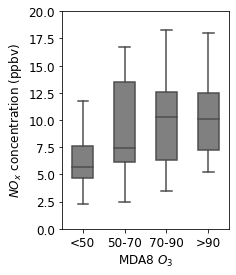

In [40]:
# bin by MDA8 O3
df_plot_NOx['MDA8_bin'] = pd.cut(df_plot_NOx['MDA8'], bins=[0,50,70,90,120], 
                             labels=['<50','50-70','70-90','>90'])
df_plot_NOx = df_plot_NOx.reset_index()

# make bar plot
fig, ax=plt.subplots(1, figsize=(3,4))
sns.boxplot(x='MDA8_bin', y='NOx', data=df_plot_NOx, color='grey', width=0.5, ax=ax)
plt.ylim(0,20)
plt.xlabel('MDA8 $O_3$')
plt.ylabel('$NO_x$ concentration (ppbv)')
fig.savefig('../../result/boxplot_NOx_vs_MDA8_O3.png', dpi=1200, bbox_inches='tight',facecolor='white')